<a target="_blank" rel="noopener noreferrer" href="https://colab.research.google.com/github/ccaudek/ds4psy_2023/blob/main/05_covid.ipynb">![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)</a>

(counterfactual-inference-covid-notebook)=
# Inferenza controfattuale

Il ragionamento causale e il pensiero controfattuale sono argomenti davvero interessanti, ma anche complessi. Tuttavia, possiamo progredire nella comprensione di queste idee attraverso esempi relativamente semplici. Questo notebook si concentra sui concetti e sull'implementazione pratica del ragionamento causale Bayesiano utilizzando PyMC.

Per fare questo useremo un esempio importante ma triste relativo al calcolo delle morti in eccesso dovute al COVID-19. A tal proposito, le idee presentate in questo notebook si sovrappongono fortemente a quelle proposte da {cite:t}`brodersen2015inferring`. In pratica, cercheremo di stimare il numero di 'morti in eccesso' dall'inizio della pandemia di COVID-19, utilizzando dati provenienti dall'Inghilterra e dal Galles. Le morti in eccesso sono definite come:

$$
\text{Morti in eccesso} = \text{Morti osservate} - \text{Morti attese (controfattuali)}
$$

Fare un'affermazione sulle morti in eccesso richiede un ragionamento causale e controfattuale. Mentre il numero di morti segnalate non è altro che una misura (sicuramente rumorosa) di un fatto realmente osservabile nel mondo, le morti attese non sono misurabili perché non si realizzano mai nella nostra linea temporale. In altre parole, l'idea delle morti attese è un esperimento controfattuale in cui ci poniamo la domanda "Cosa sarebbe/succederà se?".

Questo notebook rappresenta una versione semplificata del [notebook originale](https://www.pymc.io/projects/examples/en/latest/causal_inference/excess_deaths.html#id32) disponibile sul sito ufficiale di PyMC. La differenza fondamentale risiede nel numero di variabili predittive utilizzate. Nel notebook originale, il modello prende in considerazione tre predittori per il numero di morti nell'era pre-covid: l'anno, il mese e la temperatura. In questo tutorial, per ragioni di semplicità, la variabile del mese è stata omessa. Nonostante questa semplificazione, i risultati rimangono in gran parte analoghi a quelli presentati nel tutorial originale.

## Preparazione del Notebook

In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns
import scipy as sc
import statistics as st
import pymc as pm
import pymc.sampling_jax
import pytensor.tensor as pt
import xarray as xr
import arviz as az
import warnings

warnings.filterwarnings("ignore", category=UserWarning)
warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", category=Warning)

/Users/corrado/opt/anaconda3/envs/pymc_env/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
%config InlineBackend.figure_format = 'retina'
RANDOM_SEED = 12345
rng = np.random.default_rng(RANDOM_SEED)
az.style.use("arviz-darkgrid")
sns.set_theme(palette="colorblind")

Utilizzeremo qui una serie di funzioni che consento di genereare i grafici delle quantità di interesse con maggiore facilità. Per i nostri scopi, non è importante capire come sono state scritte tali funzioni.

In [3]:
def ZeroSumNormal(name, *, sigma=None, active_dims=None, dims, model=None):
    model = pm.modelcontext(model=model)

    if isinstance(dims, str):
        dims = [dims]

    if isinstance(active_dims, str):
        active_dims = [active_dims]

    if active_dims is None:
        active_dims = dims[-1]

    def extend_axis(value, axis):
        n_out = value.shape[axis] + 1
        sum_vals = value.sum(axis, keepdims=True)
        norm = sum_vals / (pt.sqrt(n_out) + n_out)
        fill_val = norm - sum_vals / pt.sqrt(n_out)
        out = pt.concatenate([value, fill_val], axis=axis)
        return out - norm

    dims_reduced = []
    active_axes = []
    for i, dim in enumerate(dims):
        if dim in active_dims:
            active_axes.append(i)
            dim_name = f"{dim}_reduced"
            if name not in model.coords:
                model.add_coord(dim_name, length=len(model.coords[dim]) - 1, mutable=False)
            dims_reduced.append(dim_name)
        else:
            dims_reduced.append(dim)

    raw = pm.Normal(f"{name}_raw", sigma=sigma, dims=dims_reduced)
    for axis in active_axes:
        raw = extend_axis(raw, axis)
    return pm.Deterministic(name, raw, dims=dims)


def format_x_axis(ax, minor=False):
    # major ticks
    ax.xaxis.set_major_formatter(mdates.DateFormatter("%Y %b"))
    ax.xaxis.set_major_locator(mdates.YearLocator())
    ax.grid(which="major", linestyle="-", axis="x")
    # minor ticks
    if minor:
        ax.xaxis.set_minor_formatter(mdates.DateFormatter("%Y %b"))
        ax.xaxis.set_minor_locator(mdates.MonthLocator())
        ax.grid(which="minor", linestyle=":", axis="x")
    # rotate labels
    for label in ax.get_xticklabels(which="both"):
        label.set(rotation=70, horizontalalignment="right")


def plot_xY(x, Y, ax):
    quantiles = Y.quantile((0.025, 0.25, 0.5, 0.75, 0.975), dim=("chain", "draw")).transpose()

    az.plot_hdi(
        x,
        hdi_data=quantiles.sel(quantile=[0.025, 0.975]),
        fill_kwargs={"alpha": 0.25},
        smooth=False,
        ax=ax,
    )
    az.plot_hdi(
        x,
        hdi_data=quantiles.sel(quantile=[0.25, 0.75]),
        fill_kwargs={"alpha": 0.5},
        smooth=False,
        ax=ax,
    )
    ax.plot(x, quantiles.sel(quantile=0.5), color="C1", lw=3)


# default figure sizes
figsize = (10, 5)

## Calcolo delle morti in eccesso dovute al COVID-19

Esamineremo i dati resi disponibili sul sito ufficiale di PyMC. Sebbene sia possibile condurre l'analisi utilizzando dati italiani, opteremo per i dati forniti sul sito per motivi di semplicità.

In [4]:
df = pd.read_csv("../data/deaths_and_temps_england_wales.csv")
df.head()

,date,temp,deaths,year,month,t,pre
0,2006-01-01,3.8,49124,2006,1,0,True
1,2006-02-01,3.4,42664,2006,2,1,True
2,2006-03-01,3.9,49207,2006,3,2,True
3,2006-04-01,7.4,40645,2006,4,3,True
4,2006-05-01,10.7,42425,2006,5,4,True


In [5]:
df["date"] = pd.to_datetime(df["date"])
df = df.set_index("date")

Lo scopo delle due righe precedenti è convertire una colonna del DataFrame `df` in un formato data/tempo e impostarla come indice del DataFrame. Vediamo in dettaglio cosa fanno:

1. `df["date"] = pd.to_datetime(df["date"])`: Questa riga prende la colonna "date" del DataFrame `df` e la converte in un formato data/tempo utilizzando la funzione `pd.to_datetime()`. Questa funzione è molto utile quando si lavora con serie temporali, poiché facilita la manipolazione e l'analisi dei dati. Dopo questa operazione, la colonna "date" sarà di tipo `datetime64`.

2. `df = df.set_index("date")`: Questa riga imposta la colonna "date" come indice del DataFrame. Gli indici in un DataFrame pandas servono per etichettare le righe, facilitando così il filtraggio, la selezione e altre operazioni. Impostare una colonna di date come indice è particolarmente utile quando si lavora con serie temporali, in quanto consente di eseguire facilmente operazioni come il riordinamento dei dati in base alla data o l'esecuzione di calcoli che coinvolgono intervalli di tempo.

Ora dividiamo il DataFrame `df` in due DataFrame distinti, corrispondenti al periodo pre e post insorgenza del COVID-19.

In [6]:
pre = df[df.index < "2020"]
post = df[df.index >= "2020"]

In [7]:
pre.head()

,temp,deaths,year,month,t,pre
date,,,,,,
2006-01-01,3.8,49124,2006,1,0,True
2006-02-01,3.4,42664,2006,2,1,True
2006-03-01,3.9,49207,2006,3,2,True
2006-04-01,7.4,40645,2006,4,3,True
2006-05-01,10.7,42425,2006,5,4,True


La variabile `t` è un indice che identifica la sequenza temporale delle misurazioni: 12 mesi per 14 anni.

In [11]:
14*12

168

In [8]:
pre["t"]

date
2006-01-01      0
2006-02-01      1
2006-03-01      2
2006-04-01      3
2006-05-01      4
             ... 
2019-08-01    163
2019-09-01    164
2019-10-01    165
2019-11-01    166
2019-12-01    167
Name: t, Length: 168, dtype: int64

Generiamo un grafico con il numero di morti in funzione del tempo, distinguendo tra prima e dopo l'insorgenza del COVID-19.

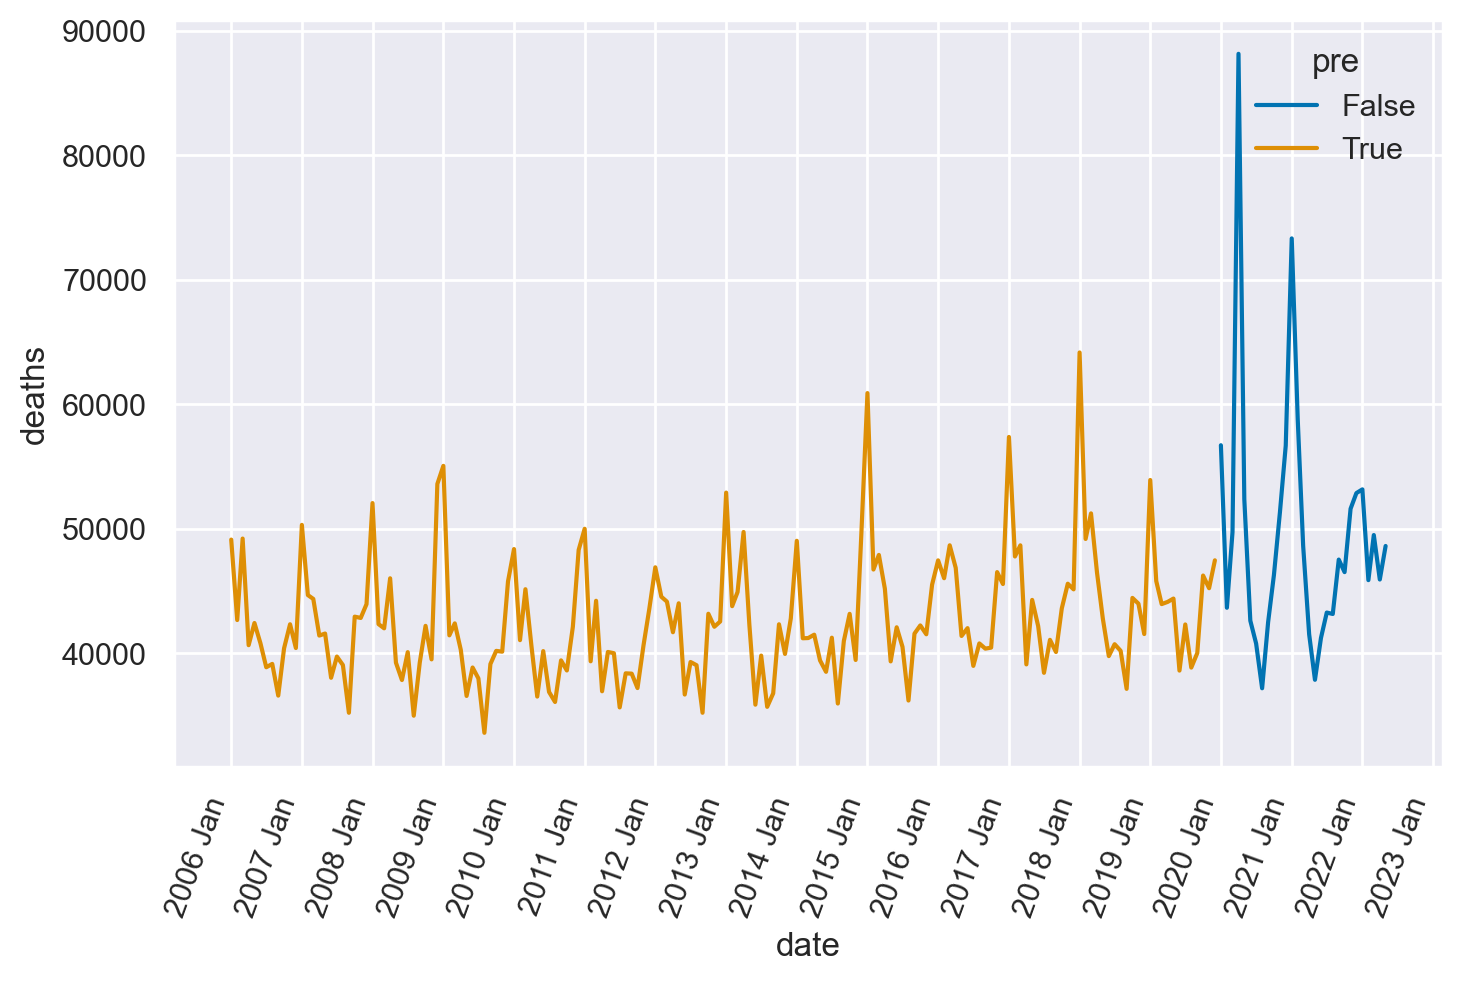

In [9]:
ax = sns.lineplot(data=df, x="date", y="deaths", hue="pre")
format_x_axis(ax)

Esaminiamo i dati relativi al periodo pre-COVID-19. La serie temporale evidenzia una tendenza generale all'incremento del numero di decessi nel corso del tempo, oltre a un marcato effetto stagionale. Quest'ultimo è attribuibile alle fluttuazioni della temperatura.

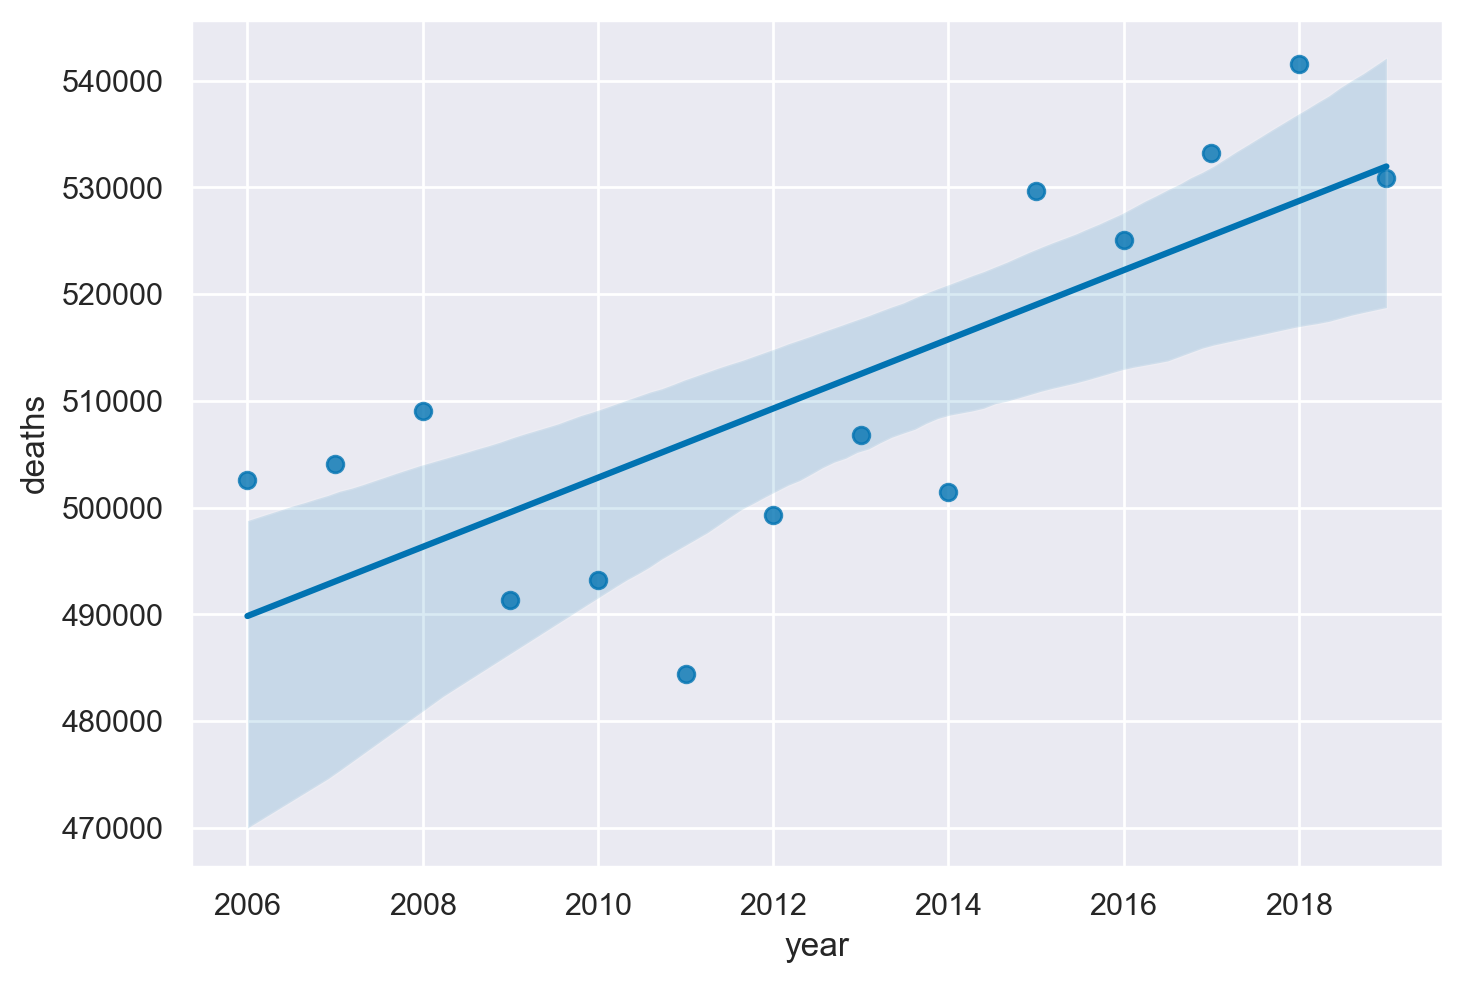

In [10]:
annual_deaths = pd.DataFrame(pre.groupby("year")["deaths"].sum()).reset_index()
sns.regplot(x="year", y="deaths", data=annual_deaths);

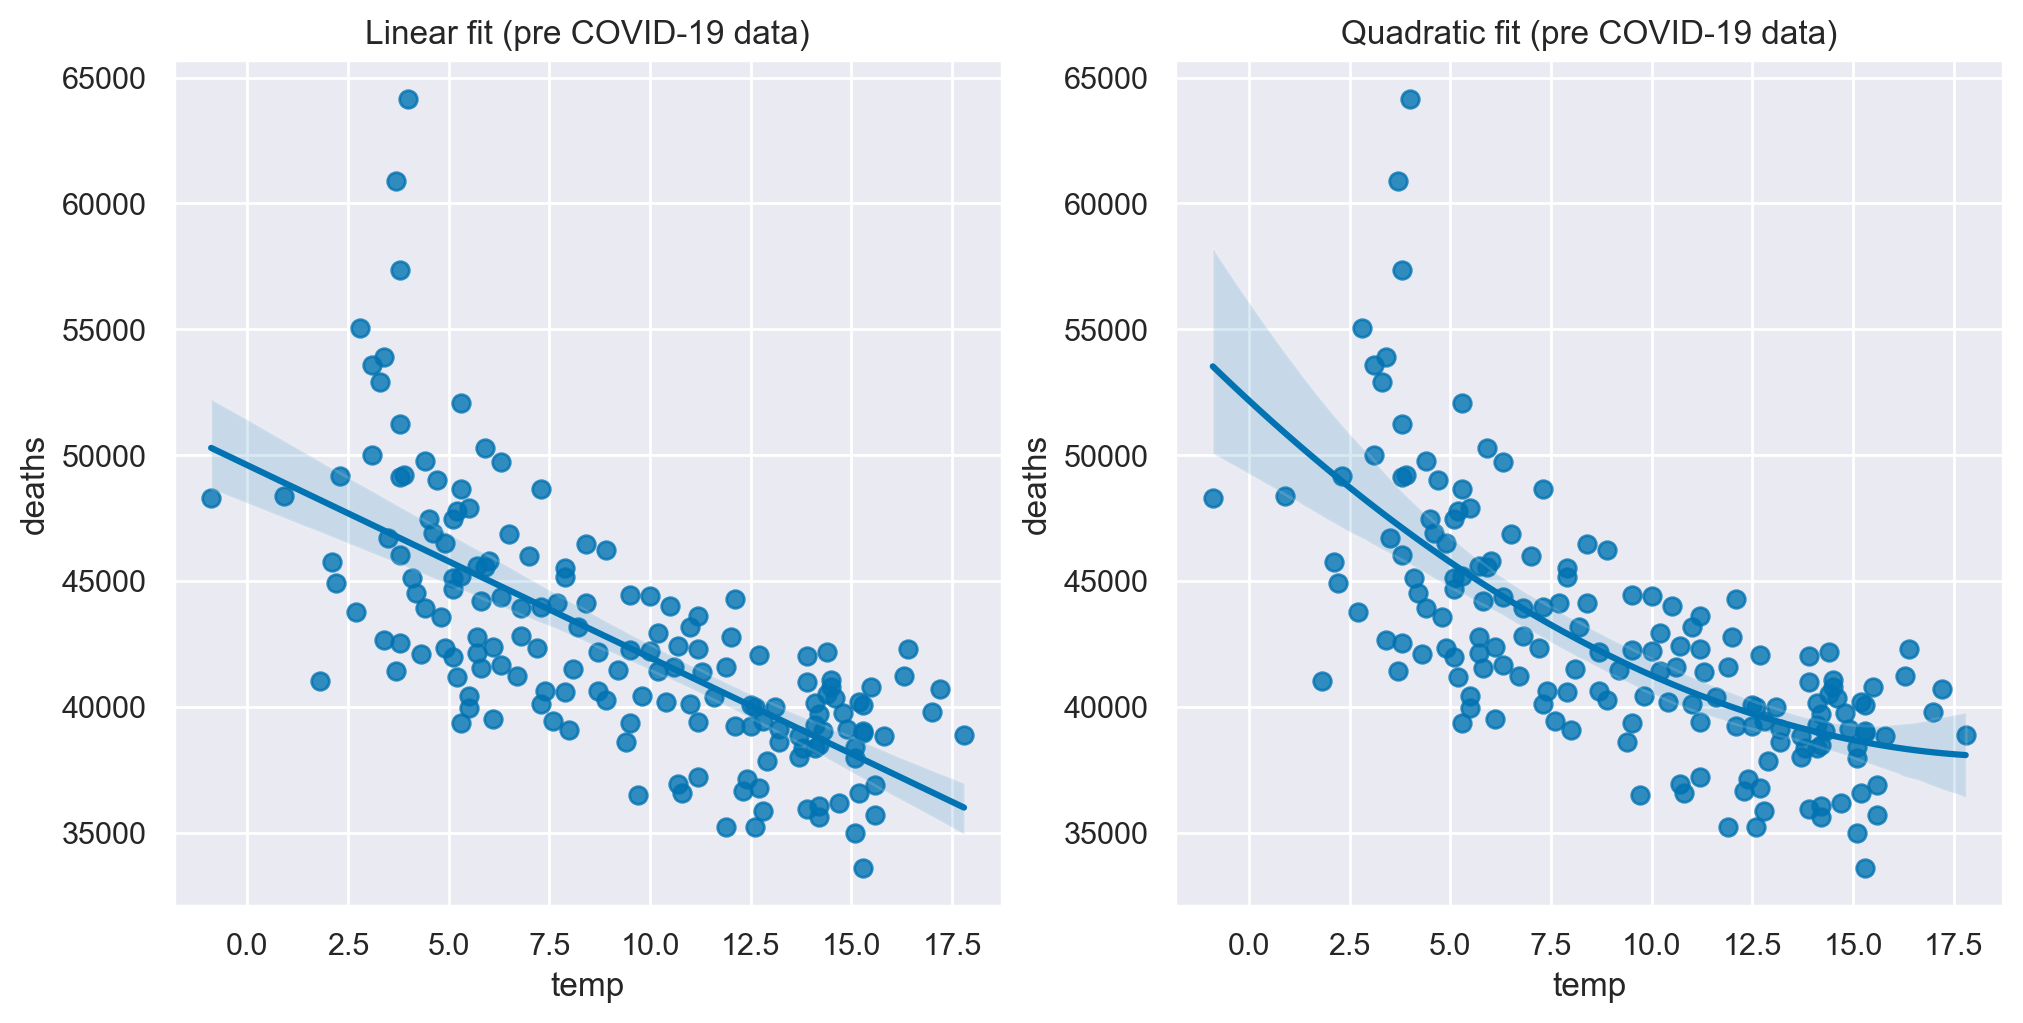

In [11]:
fig, ax = plt.subplots(1, 2, figsize=figsize)
sns.regplot(x="temp", y="deaths", data=pre, scatter_kws={"s": 40}, order=1, ax=ax[0])
ax[0].set(title="Linear fit (pre COVID-19 data)")
sns.regplot(x="temp", y="deaths", data=pre, scatter_kws={"s": 40}, order=2, ax=ax[1])
ax[1].set(title="Quadratic fit (pre COVID-19 data)");

Per una descrizione più accurata, l'effetto della temperatura potrebbe essere modellato attraverso una funzione quadratica. Tuttavia, per semplicità, opteremo per una rappresentazione lineare. Nei dati relativi al periodo pre-COVID-19, un aumento di un grado nella temperatura è associato a una diminuzione media di 764 decessi.

In [12]:
slope, intercept = np.polyfit(pre["temp"], pre["deaths"], 1)
print(f"{slope:.0f} deaths/degree")

-764 deaths/degree


Per il periodo pre-COVID-19, proponiamo dunque un modello di regressione multipla che considera due predittori: l'anno e la temperatura. L'anno è incluso nel modello per tener conto della tendenza lineare all'aumento del numero di morti nel tempo, mentre la temperatura è considerata in quanto fattore significativo.

Il modello matematico è espresso come segue:

$$
\text{deaths}_t \sim \text{TruncatedNormal}(\mu_t, \sigma), \quad \mu_t = \alpha + \beta_1 \cdot \text{time}_t + \beta_2 \cdot \text{temp}_t
$$

In questa formula, $\text{deaths}_t$ rappresenta il numero di morti al tempo $t$ e viene modellato come una variabile casuale con distribuzione TruncatedNormal avente media $\mu_t$ e deviazione standard $\sigma$. La media $\mu_t$ è una funzione lineare del tempo ($\text{time}_t$) e della temperatura ($\text{temp}_t$), dove $\alpha$ è il termine di intercetta e $\beta_1$ e $\beta_2$ sono i coefficienti di regressione.

In un'ottica bayesiana, ciascun parametro del modello è trattato come una variabile casuale dotata di una distribuzione a priori. Utilizzeremo le seguenti distribuzioni a priori:

- $\alpha$ (Intercept): distribuzione a priori Normale con media 40.000 e deviazione standard 10.000.
- $\beta_1$ (Coefficiente temporale): distribuzione a priori TruncatedNormal con media 0 e deviazione standard 50, limitata a valori positivi.
- $\beta_2$ (Coefficiente per la temperatura): distribuzione a priori Normale con media 0 e deviazione standard 200.
- $\sigma$: distribuzione a priori HalfNormal con deviazione standard 2.000.

L'obiettivo è quindi quello di stimare la distribuzione a posteriori di questi parametri alla luce dei dati osservati, permettendo così inferenze probabilistiche sul numero di morti in relazione al tempo e alla temperatura.

In [13]:
with pm.Model() as model:
    # observed predictors and outcome
    time = pm.MutableData("time", pre["t"].to_numpy(), dims="t")
    temp = pm.MutableData("temp", pre["temp"].to_numpy(), dims="t")
    deaths = pm.MutableData("deaths", pre["deaths"].to_numpy(), dims="t")

    # priors
    alpha = pm.Normal("intercept", 40_000, 10_000)
    beta_1 = pm.TruncatedNormal("linear trend", 0, 50, lower=0)
    beta_2 = pm.Normal("temp coeff", 0, 200)

    # the actual linear model
    mu = pm.Deterministic(
        "mu",
        alpha + (beta_1 * time) + (beta_2 * temp),
        dims="t",
    )
    sigma = pm.HalfNormal("sigma", 2_000)
    # likelihood
    pm.TruncatedNormal("obs", mu=mu, sigma=sigma, lower=0, observed=deaths, dims="t")

L'utilizzo di una distribuzione TruncatedNormal con un limite inferiore di zero per il numero di morti è una scelta modellistica che riflette alcune considerazioni pratiche e teoriche. Il numero di morti non può essere negativo, quindi un limite inferiore di zero è una scelta naturale per rispettare questa restrizione. Inoltre, le distribuzioni troncate sono spesso più facili da gestire computazionalmente rispetto ad altre distribuzioni asimmetriche che potrebbero essere usate per modellare conteggi come il numero di morti (ad esempio, la distribuzione di Poisson o la distribuzione binomiale negativa). Troncare una distribuzione normale conserva molte delle sue proprietà matematiche desiderabili. Per queste ragioni, la distribuzione TruncatedNormal con un limite inferiore di zero è una scelta ragionevole quando si modellano variabili che non possono assumere valori negativi, come nel caso del numero di morti.

Eseguiamo il campionamento usando i dati pre-COVID-19.

In [14]:
with model:
    idata = pm.sample(random_seed=rng)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [intercept, linear trend, temp coeff, sigma]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 50 seconds.


Esaminiamo ora l'adeguatezza del modello confrontando le predizioni del modello con i dati osservati.

In [15]:
with model:
    idata.extend(pm.sample_posterior_predictive(idata, random_seed=RANDOM_SEED))

Sampling: [obs]


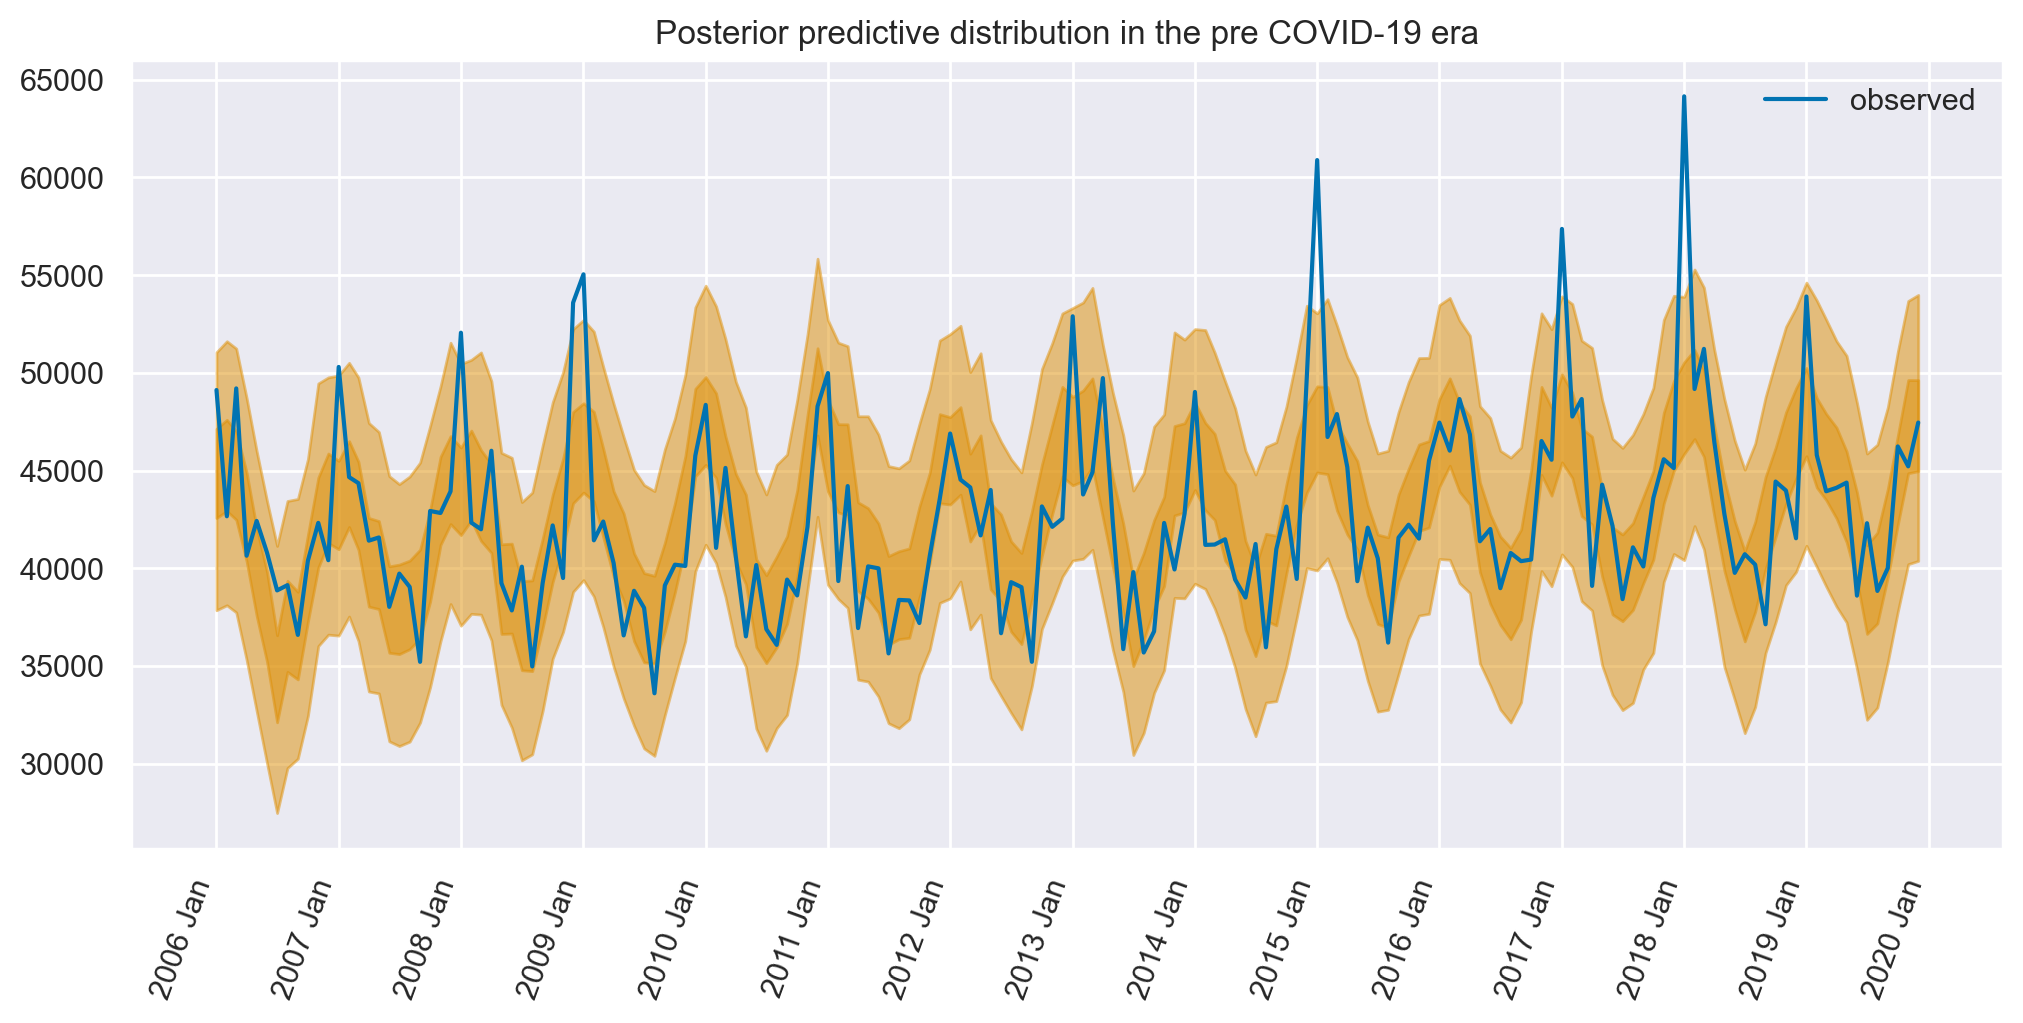

In [16]:
fig, ax = plt.subplots(figsize=figsize)

az.plot_hdi(pre.index, idata.posterior_predictive["obs"], hdi_prob=0.5, smooth=False)
az.plot_hdi(pre.index, idata.posterior_predictive["obs"], hdi_prob=0.95, smooth=False)
ax.plot(pre.index, pre["deaths"], label="observed")
format_x_axis(ax)
ax.set(title="Posterior predictive distribution in the pre COVID-19 era")
plt.legend();

Il modello, pur non essendo esente da limitazioni, dimostra un'alta capacità predittiva del numero di decessi in relazione al tempo, avvalendosi unicamente del tempo e della temperatura come variabili indipendenti.

Ora focalizziamoci sui dati osservati, aggregati esclusivamente in base al fattore temporale e trascurando l'effetto della temperatura, per metterli a confronto con le stime fornite dal modello.

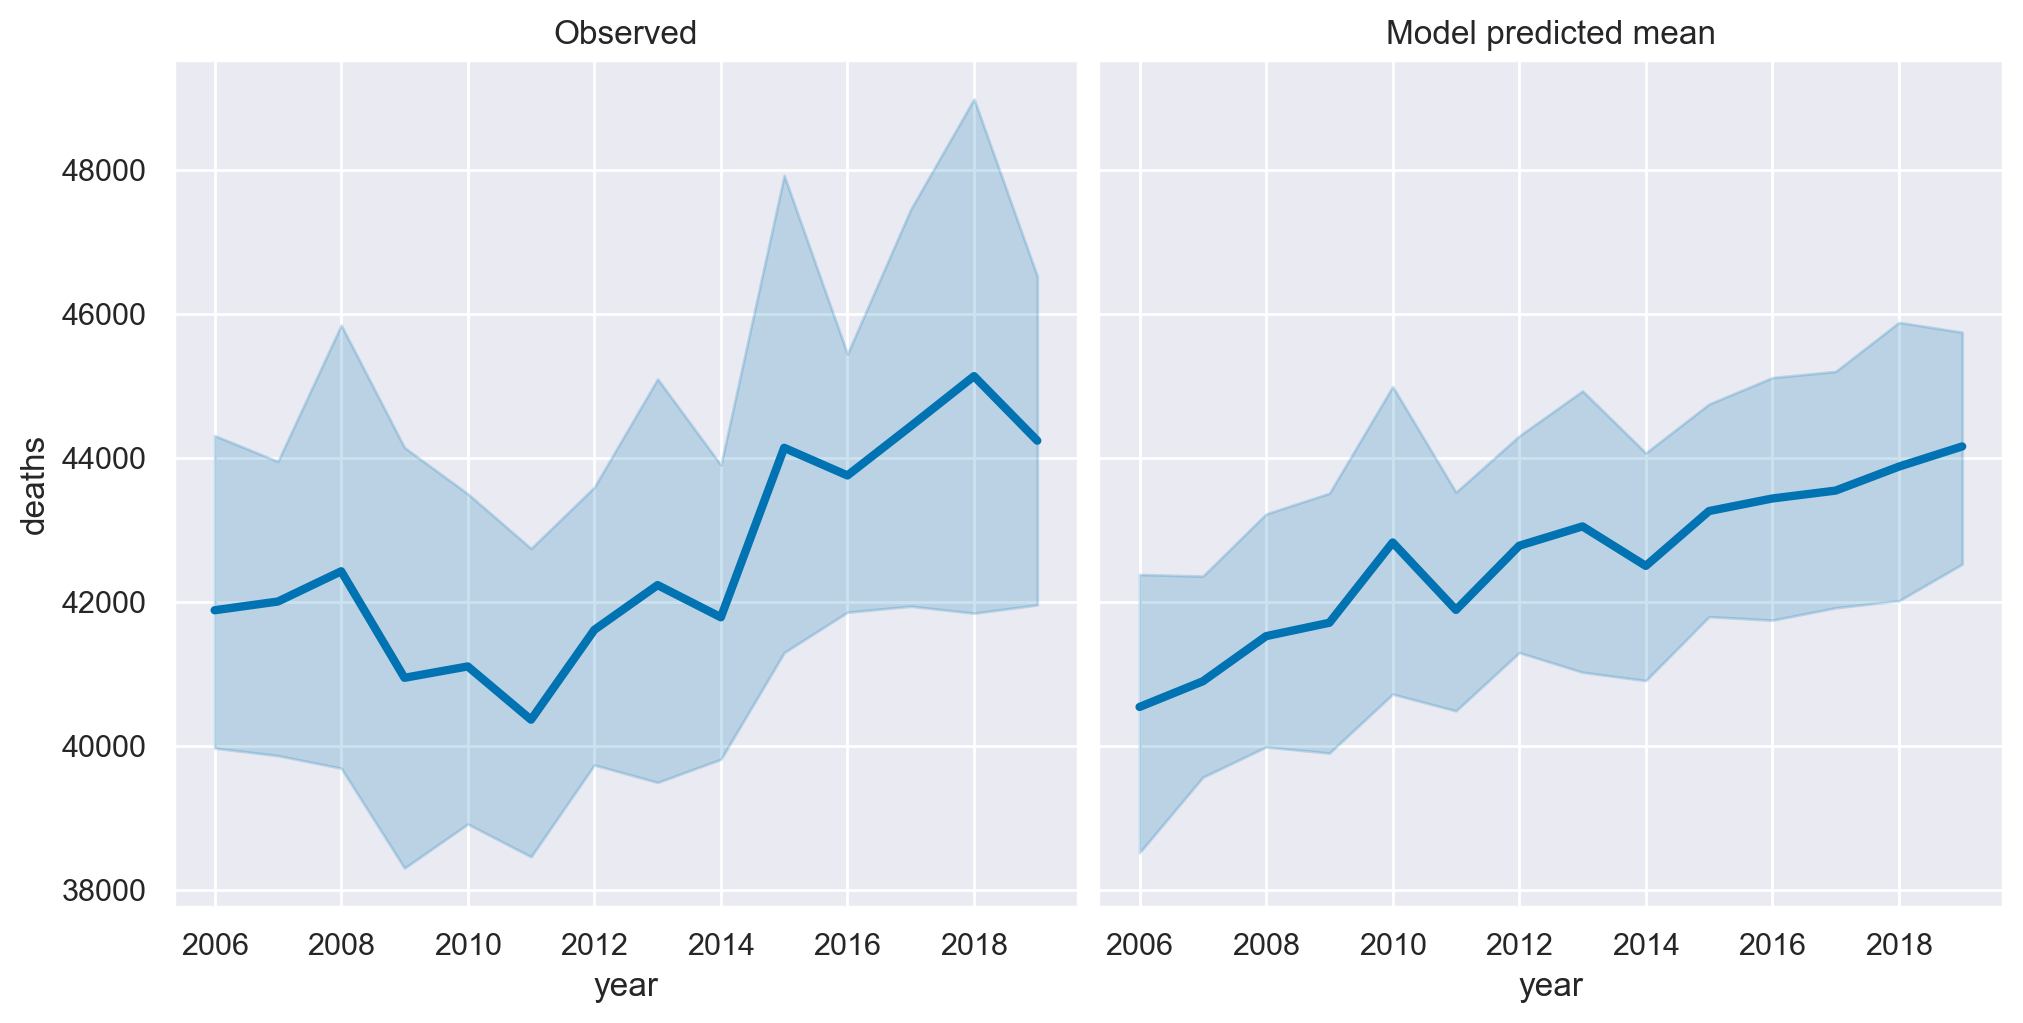

In [17]:
temp = idata.posterior["mu"].mean(dim=["chain", "draw"]).to_dataframe()
pre = pre.assign(deaths_predicted=temp["mu"].values)

fig, ax = plt.subplots(1, 2, figsize=figsize, sharey=True)
sns.lineplot(data=pre, x="year", y="deaths", ax=ax[0], lw=3)
ax[0].set(title="Observed")
sns.lineplot(data=pre, x="year", y="deaths_predicted", ax=ax[1], lw=3)
ax[1].set(title="Model predicted mean");

Possiamo notare una buona corrispondenza tra i dati osservati e le predizioni del modello.

## Inferenza controfattuale

Ora utilizzeremo il metodo `sample_posterior_predictive` per generare campioni dalla distribuzione predittiva a posteriori del modello, dato un nuovo set di dati sui predittori ("time" e "temp" in questo caso, per gli anni 2006-2020). In altre parole, stiamo cercando di capire quale sarebbe la distribuzione del numero di morti in anni futuri (2021-2023) dati i nuovi valori per il tempo e la temperatura, assumendo che il "meccanismo generatore dei dati" non cambi nel tempo -- ovvero assumiamo che il Covid-19 non si sia verificato, insieme a tutte le altre cose che lo hanno accompagnato, come la riduzione dei servizi sanitari che, normalmente, sarebbero stati presenti.

Questo è un esempio di "estrapolazione" nel senso che stiamo utilizzando il modello addestrato su un certo set di dati per fare previsioni su un diverso set di dati che non è stato utilizzato durante l'addestramento del modello. Quindi, in termini semplici, stiamo cercando di prevedere come il numero di morti cambierà in funzione del tempo e della temperatura in anni futuri (2021-2023), sotto l'ipotesi che la relazione tra queste variabili e il numero di morti rimanga costante.

In [18]:
with model:
    pm.set_data(
        {
            "time": post["t"].to_numpy(),
            "temp": post["temp"].to_numpy(),
        }
    )
    counterfactual = pm.sample_posterior_predictive(
        idata, var_names=["obs"], random_seed=rng
    )

Sampling: [obs]


La figura illustra le previsioni sul numero di morti per gli anni 2021-2023, basate esclusivamente sui dati relativi al tempo e alla temperatura. Queste stime presuppongono che l'impatto di queste variabili sia analogo a quello osservato nel periodo 2006-2020.

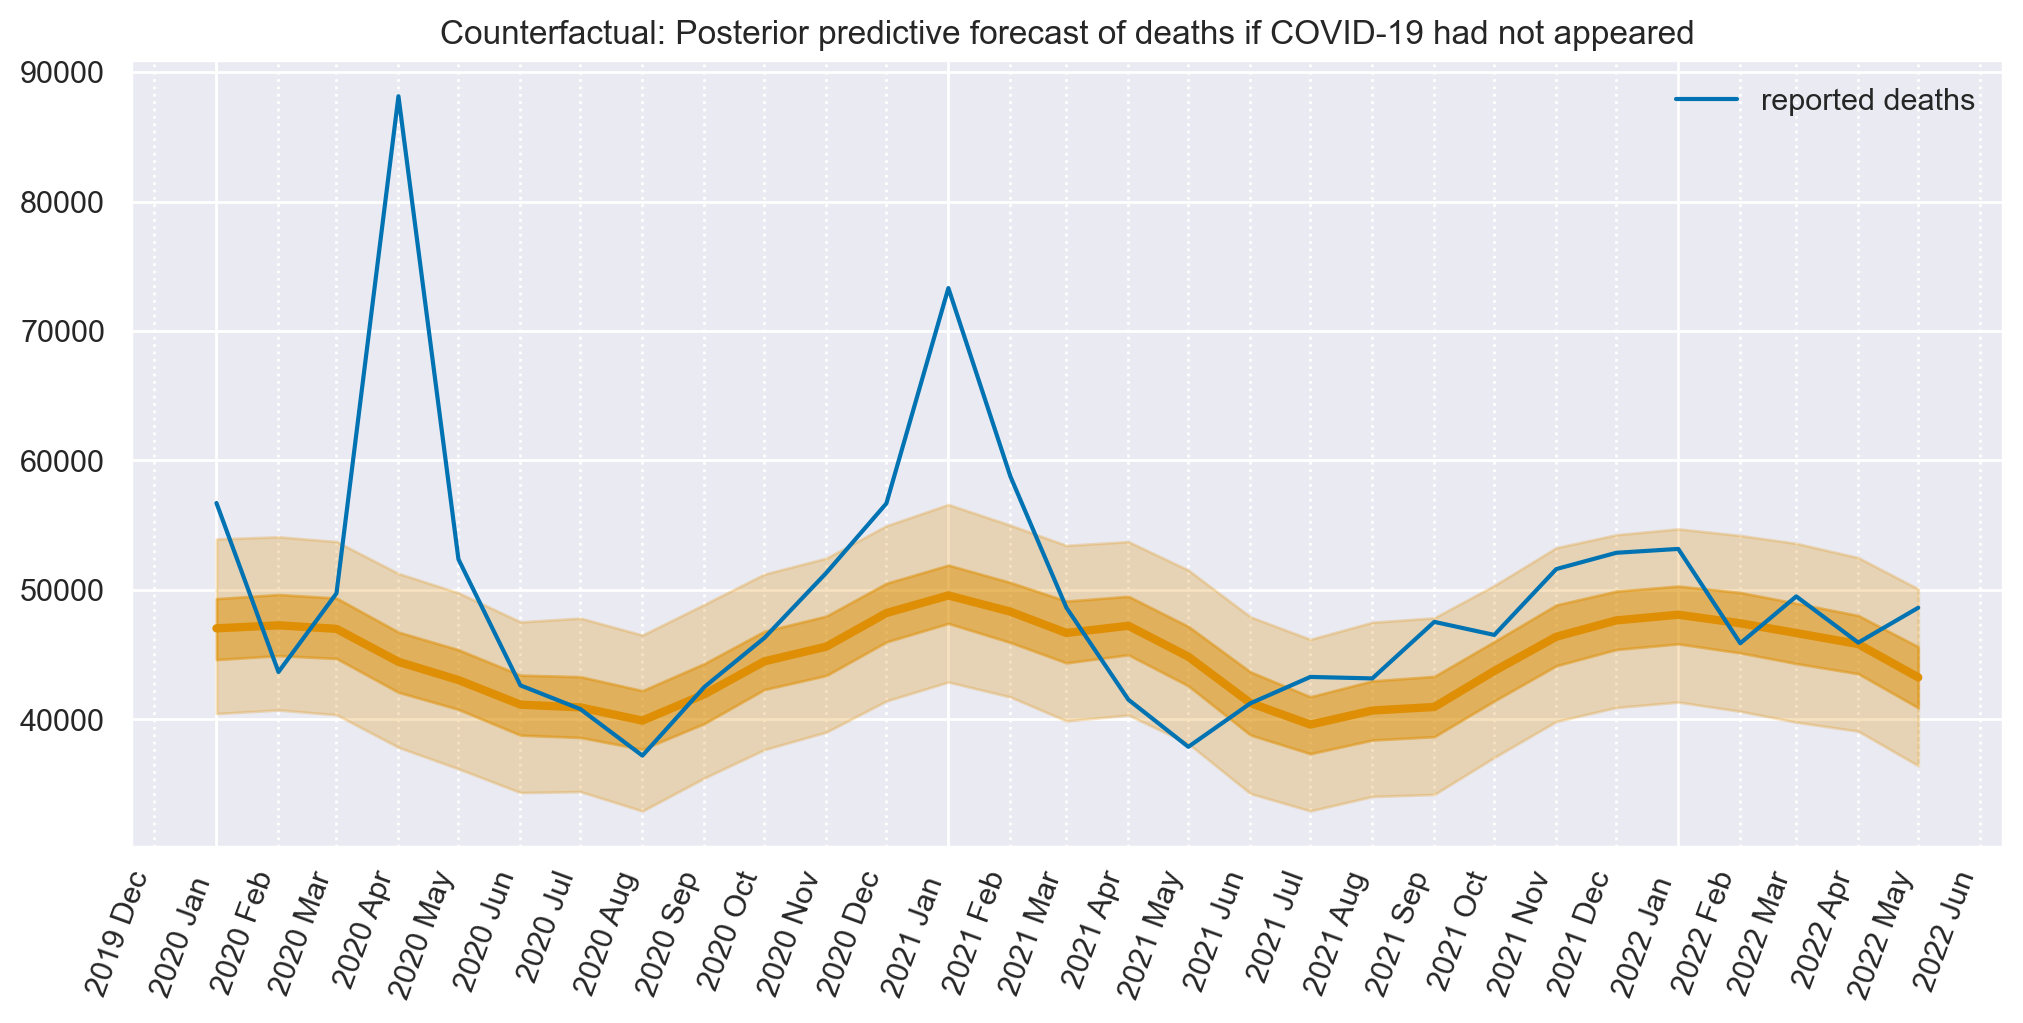

In [19]:
fig, ax = plt.subplots(figsize=figsize)

plot_xY(post.index, counterfactual.posterior_predictive["obs"], ax)
format_x_axis(ax, minor=True)
ax.plot(post.index, post["deaths"], label="reported deaths")
ax.set(title="Counterfactual: Posterior predictive forecast of deaths if COVID-19 had not appeared")
plt.legend();

Alla figura è sovrapposta una spezzata (la linea blu) che, nel periodo post-covid, descrive il numero effettivo di morti.

Ora abbiamo gli elementi necessari per calcolare il numero di morti in eccesso. In particolare, il numero di morti segnalato e la previsione controfattuale Bayesiana su quanti sarebbero morti se nulla fosse cambiato dal periodo pre a quello post-COVID-19.

## Numero di morti in eccesso dall'onset del Covid-19

Ora utilizzeremo il numero previsto di morti nello scenario controfattuale e lo confronteremo con il numero di morti effettivamente osservati per ottenere la nostra stima controfattuale delle morti in eccesso.

In [20]:
# convert deaths into an XArray object with a labelled dimension to help in the next step
deaths = xr.DataArray(post["deaths"].to_numpy(), dims=["t"])
deaths

<xarray.DataArray (t: 29)>
array([56704, 43650, 49723, 88141, 52363, 42614, 40778, 37184, 42494,
       46282, 51317, 56672, 73315, 58767, 48624, 41513, 37864, 41223,
       43264, 43151, 47520, 46511, 51602, 52859, 53158, 45869, 49489,
       45919, 48611])
Dimensions without coordinates: t

In [73]:
counterfactual.posterior_predictive["obs"]

<xarray.DataArray 'obs' (chain: 4, draw: 1000, t: 29)>
array([[[50177.9143282 , 47122.66944358, 43609.79060885, ...,
         42682.04978756, 44188.13060844, 38974.38744412],
        [45853.59094075, 49274.28725688, 45893.2610516 , ...,
         48769.12225415, 47639.84133954, 42041.63086726],
        [46600.37052219, 53232.24580814, 42014.8055475 , ...,
         47735.78646001, 48597.24545377, 43700.93427056],
        ...,
        [48140.26398147, 49758.92427899, 49433.41310742, ...,
         53668.36104864, 39926.4157674 , 48379.83274395],
        [45442.87602889, 42981.79670225, 48114.08193253, ...,
         48463.68558482, 43765.75882523, 43318.48751183],
        [42961.66126204, 49002.20934075, 46736.80552095, ...,
         48724.57243188, 45218.10565951, 47130.64346717]],

       [[47406.71161258, 39634.49641191, 46000.57650776, ...,
         51096.2821484 , 41717.74638697, 44559.18039028],
        [47281.34927443, 47484.95408753, 43408.10846075, ...,
         52369.24924382, 47884.99474226, 42637.92228699],
        [46176.2850197 , 54125.68138064, 50648.48919738, ...,
         44120.7783835 , 44821.75669193, 44981.1042854 ],
...
        [45811.87915563, 47226.31893129, 46229.29300514, ...,
         50342.89187747, 41788.88000174, 46414.50546739],
        [54146.17266825, 43306.53096143, 44290.62429484, ...,
         46443.46238003, 42121.82957989, 41718.45426722],
        [46784.20929255, 51776.82908603, 40826.04962446, ...,
         44440.66633907, 45413.86955642, 39574.1828162 ]],

       [[47256.65285355, 47294.74343594, 43196.42785118, ...,
         41255.86666922, 47023.68622421, 45415.82664967],
        [46078.44588041, 48230.39798606, 43415.90303596, ...,
         48842.12387992, 49157.51254356, 38465.7218291 ],
        [49282.75718885, 48632.77164409, 39949.88918217, ...,
         46230.26924915, 47894.63759367, 44504.21148463],
        ...,
        [50025.90876729, 47606.12725625, 49350.02849479, ...,
         46974.31628753, 49045.20634816, 46178.15728763],
        [48052.67162372, 48163.71109786, 45241.77545997, ...,
         47582.77152414, 47387.8654248 , 43325.30083166],
        [51985.92420518, 49724.21915241, 47728.70484613, ...,
         48796.47500249, 46347.52830453, 34980.27599878]]])
Coordinates:
  * chain    (chain) int64 0 1 2 3
  * draw     (draw) int64 0 1 2 3 4 5 6 7 8 ... 992 993 994 995 996 997 998 999
  * t        (t) int64 0 1 2 3 4 5 6 7 8 9 10 ... 19 20 21 22 23 24 25 26 27 28

In [21]:
# do the calculation by taking the difference
excess_deaths = deaths - counterfactual.posterior_predictive["obs"]

In [22]:
# calculate the cumulative excess deaths
cumsum = excess_deaths.cumsum(dim="t")

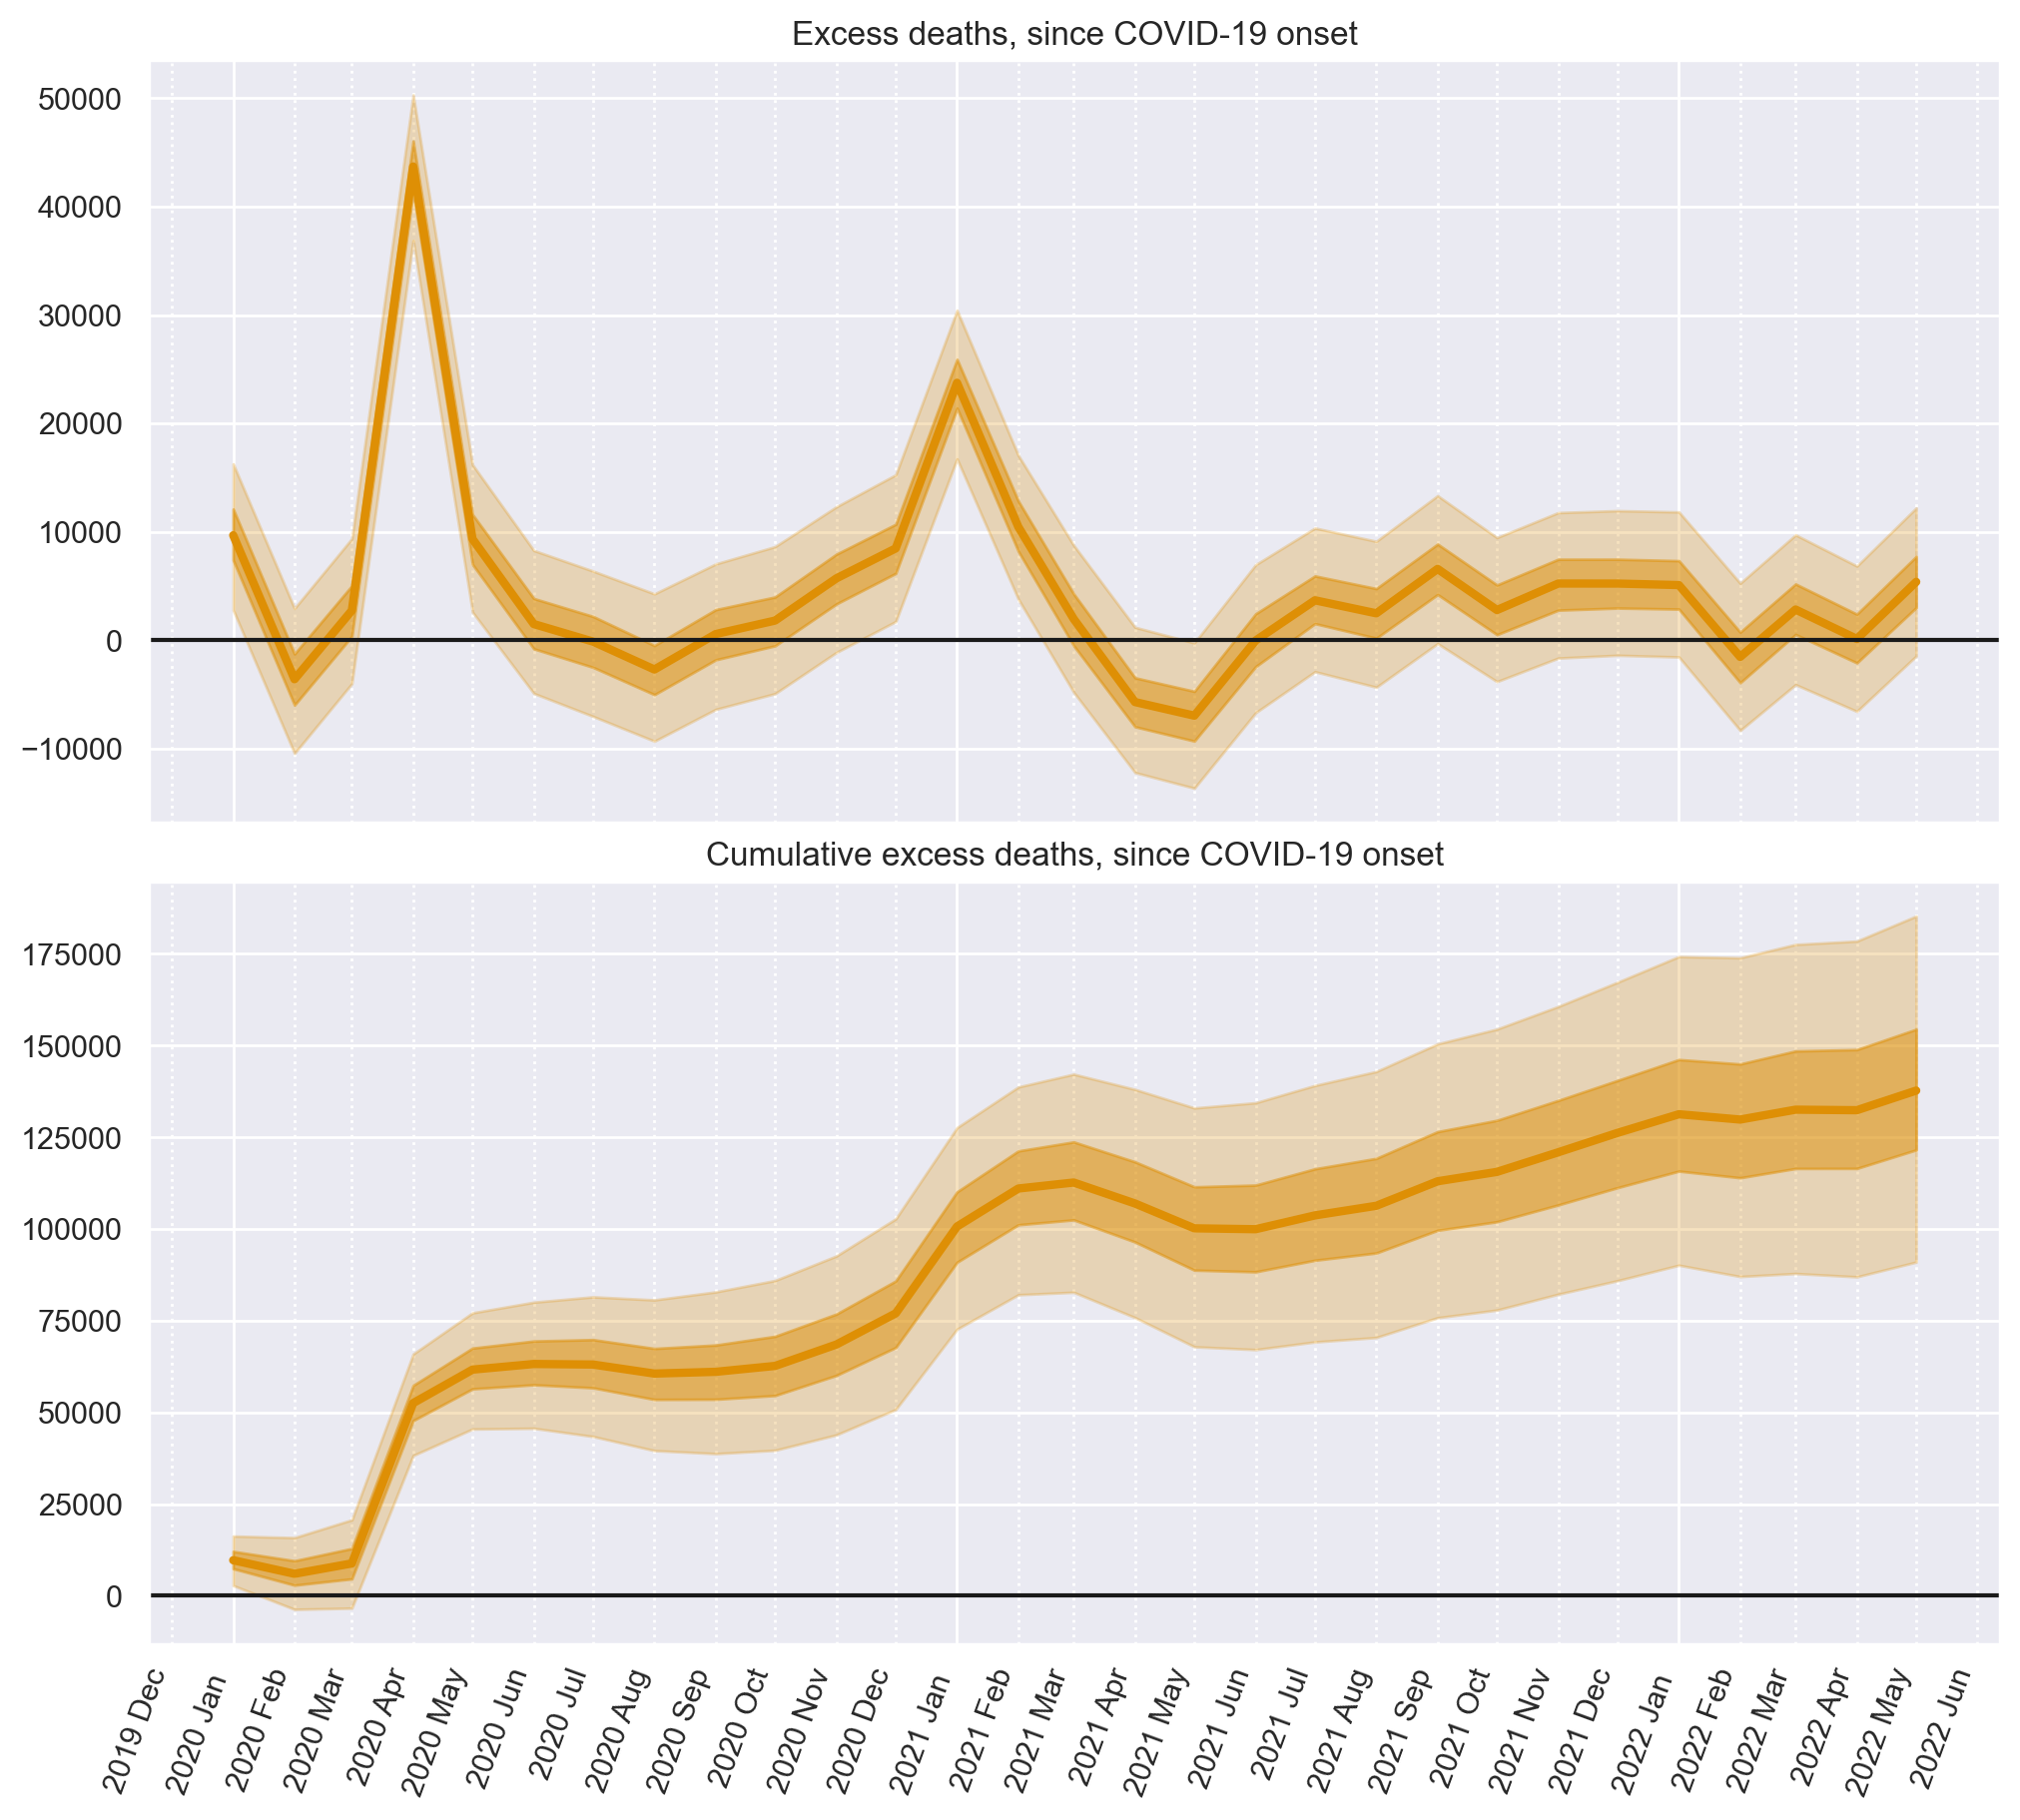

In [23]:
fig, ax = plt.subplots(2, 1, figsize=(figsize[0], 9), sharex=True)

# Plot the excess deaths
# The transpose is to keep arviz happy, ordering the dimensions as (chain, draw, t)
plot_xY(post.index, excess_deaths.transpose(..., "t"), ax[0])
format_x_axis(ax[0], minor=True)
ax[0].axhline(y=0, color="k")
ax[0].set(title="Excess deaths, since COVID-19 onset")

# Plot the cumulative excess deaths
plot_xY(post.index, cumsum.transpose(..., "t"), ax[1])
format_x_axis(ax[1], minor=True)
ax[1].axhline(y=0, color="k")
ax[1].set(title="Cumulative excess deaths, since COVID-19 onset");

In [1]:
%run ../wm.py

Watermark:
----------
Last updated: 2024-01-26T18:46:30.723337+01:00

Python implementation: CPython
Python version       : 3.11.7
IPython version      : 8.19.0

Compiler    : Clang 16.0.6 
OS          : Darwin
Release     : 23.3.0
Machine     : x86_64
Processor   : i386
CPU cores   : 8
Architecture: 64bit


